In [1]:
%reset -f
%matplotlib inline
import numpy as np
import lib.io.stan
import lib.plots.stan
import matplotlib.pyplot as plt
import os

In [2]:
data_dir = 'datasets/id002_cj'
results_dir = 'results/exp10/exp10.62'
os.makedirs(results_dir,exist_ok=True)
os.makedirs(f'{results_dir}/logs',exist_ok=True)
os.makedirs(f'{results_dir}/figures',exist_ok=True)

network = np.load(f'{data_dir}/CJ_network.npz')
SC = network['SC']
K = np.max(SC)
SC = SC / K
SC[np.diag_indices(SC.shape[0])] = 0
gain_mat = network['gain_mat']

slp = np.load(f'{data_dir}/CJ_fit_trgt.npz')['fit_trgt']
slp_ds = slp[0:-1:10,:]
slp_ds_noisy = np.random.normal(loc=0.0, scale=0.2, size=slp_ds.shape) + slp_ds
snsr_pwr = np.sum(slp_ds**2, axis=0)

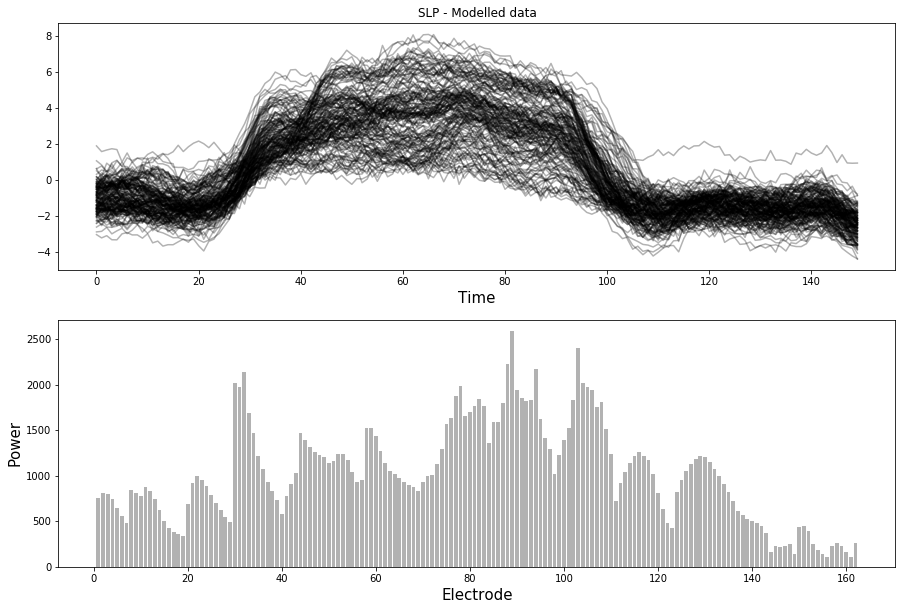

In [3]:
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot(slp_ds_noisy, color='black', alpha=0.3);
plt.xlabel('Time', fontsize=15)
plt.title('SLP - Modelled data')
plt.subplot(212)
plt.bar(np.arange(1,gain_mat.shape[0]+1), snsr_pwr, color='black', alpha=0.3)
plt.xlabel('Electrode', fontsize=15)
plt.ylabel('Power', fontsize=15)
plt.savefig(f'{results_dir}/figures/fitting_data.png')

In [7]:
nn = SC.shape[0]
ns = gain_mat.shape[0]
nt = slp_ds.shape[0]
I1 = 3.1
time_step = 0.1
x_init = -2.0*np.ones(nn)
z_init = 3.5*np.ones(nn)
# sigma = 0.1
# epsilon_slp = 0.2
# epsilon_snsr_pwr = 5


stan_fname = 'vep-snsrfit-cntr'
# # lib.utils.stan.compile('/home/anirudh/Softwares/cmdstan-2.18.0', 'vep-snsrfit-ode')

# x0_star = np.zeros(nn)
# # x_init_star = np.zeros(nn)
# # z_init_star = np.zeros(nn)
# amplitude_star = 0.0
# offset = 0.0
# K_star = 0.0
# tau0_star = 0.0


# param_init = {'x0_star':x0_star, 'amplitude_star':amplitude_star, 'offset':offset,
#               'K_star':K_star, 'tau0_star':tau0_star}
# param_init_file = 'param_init.R'
# os.makedirs(f'{results_dir}/Rfiles',exist_ok=True)
# lib.io.stan.rdump(f'{results_dir}/Rfiles/param_init.R',param_init)

max_depth = 15
delta = 0.95
fname_suffix = f'hyper_infer_md{max_depth}_delta{delta}'

data = {'nn':nn, 'ns':ns, 'nt':nt, 'I1':I1, 'time_step':time_step,
        'x_init':x_init, 'z_init':z_init, 'SC':SC, 'gain': gain_mat, 
        'slp':slp_ds_noisy, 'snsr_pwr':snsr_pwr}
input_Rfile = f'fit_data_snsrfit_ode_{fname_suffix}.R'
os.makedirs(f'{results_dir}/Rfiles',exist_ok=True)
lib.io.stan.rdump(f'{results_dir}/Rfiles/{input_Rfile}',data)

In [12]:
%%bash -s "$stan_fname"
stancompile.sh $1

/home/anirudh/Academia/projects/vep.stan

--- Translating Stan model to C++ code ---
bin/stanc  /home/anirudh/Academia/projects/vep.stan/vep-snsrfit-cntr.stan --o=/home/anirudh/Academia/projects/vep.stan/vep-snsrfit-cntr.hpp
Model name=vep_snsrfit_cntr_model
Input file=/home/anirudh/Academia/projects/vep.stan/vep-snsrfit-cntr.stan
Output file=/home/anirudh/Academia/projects/vep.stan/vep-snsrfit-cntr.hpp

--- Linking C++ model ---
g++ -Wall -I . -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.66.0 -isystem stan/lib/stan_math/lib/sundials_3.1.0/include -std=c++1y -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -Wno-unused-function -Wno-uninitialized -I src -isystem stan/src -isystem stan/lib/stan_math/ -DFUSION_MAX_VECTOR_SIZE=12 -Wno-unused-local-typedefs -DEIGEN_NO_DEBUG -DNO_FPRINTF_OUTPUT -pipe   src/cmdstan/main.cpp  -O3 -o /home/anirudh/Academia/projects/vep.stan/vep-snsrfit-cntr -inclu

In [13]:
%%bash -s "$stan_fname" "$results_dir" "$input_Rfile" "$fname_suffix" "$max_depth" "$delta"

STAN_FNAME=$1
RESULTS_DIR=$2
INPUT_RFILE=$3
FNAME_SUFFIX=$4
MAX_DEPTH=$5
DELTA=$6

for i in {1..2};
do
./${STAN_FNAME} id=$((100*${i})) sample num_samples=500 num_warmup=500 \
save_warmup=1 adapt delta=${DELTA} algorithm=hmc engine=nuts max_depth=${MAX_DEPTH} \
data file=${RESULTS_DIR}/Rfiles/${INPUT_RFILE} random seed=$((987*${i})) \
output file=${RESULTS_DIR}/samples_${FNAME_SUFFIX}_chain${i}.csv refresh=10 \
&> ${RESULTS_DIR}/logs/snsrfit_ode_${FNAME_SUFFIX}_chain${i}.log &
done

In [ ]:
# import lib.io.stan
# import importlib
# importlib.reload(lib.io.stan)

# csv_fname = f'{results_dir}/samples_sigma0.10000_eps0.10000.csv'
# nwarmup = 200
# nsampling = 200
# variables_of_interest = ['lp__','accept_stat__','stepsize__','treedepth__','n_leapfrog__',\
#                          'divergent__', 'energy__','x0',  'x', 'z', 'amplitude', 'offset',\
#                          'x_init', 'z_init', 'time_step']
pstr_samples_1 = lib.io.stan.read_samples([f'{results_dir}/samples_{fname_suffix}_chain{i}.csv' for i in [1,2,3,4]]) # read sampler diagnostics and x0 for all sampling iterations
# csv_fname = 'results/exp10/exp10.4/samples_eps0.1_chain1.csv'
# nwarmup = 1000
# nsampling = 1000
# ignore_warmup = True
# variables_of_interest = ['x','z']
# pstr_samples_2 = lib.io.stan.read_samples(csv_fname,nwarmup,nsampling,ignore_warmup,variables_of_interest) # read 10 samples of hidden state variables x and z

In [ ]:
# import importlib
# importlib.reload(lib.io.stan)

syn_data = np.load('datasets/id001_ac/AC_syn_tvb_ez=59_pz=82-74.npz')
x0_true = syn_data['x0']
ez = syn_data['ez']
pz= np.concatenate((syn_data['pz_x0'], syn_data['pz_kplng']))

lib.plots.stan.x0_violin(pstr_samples_1['x0'], x0_true, ez, pz, figsize=(25,5), figname=f'{results_dir}/figures/x0_violin_{fname_suffix}.png')

ntwrk = np.load('datasets/id001_ac/AC_network.npz')
gain = ntwrk['gain_mat']
src_sig = pstr_samples_1['x']
amplitude = pstr_samples_1['amplitude_slp']
offset = pstr_samples_1['offset_slp']
slp_pp = np.zeros([src_sig.shape[0], src_sig.shape[1], gain.shape[0]])
snsr_pwr_pp = np.zeros([src_sig.shape[0], ns])
for i,sample in enumerate(src_sig):
#     seeg[i] = amplitude[i,:] * ((gain @ sample.T).T + offset[i,:]);
    slp_pp[i] = amplitude[i] * (np.log(gain @ np.exp(sample).T).T + offset[i])
    snsr_pwr_pp[i] = np.sum(slp_pp[i]**2, axis=0)

slp_pp_mean = np.mean(slp_pp, axis=0)
snsr_pwr_pp_mean = np.mean(snsr_pwr_pp, axis=0)

plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot(slp_ds, 'k', alpha=0.4)
plt.plot(slp_pp_mean,'r',alpha=0.4);
plt.title('Posterior predicted slp')
plt.xlabel('Time', fontsize=13)

plt.subplot(212)
plt.plot(snsr_pwr,'k',alpha=0.4);
plt.plot(snsr_pwr_pp_mean, 'r', alpha=0.4);
plt.title('Posterior predicted sensor power')
plt.xlabel('Sensor', fontsize=13)
plt.tight_layout()
plt.savefig(f'{results_dir}/figures/ppc_{fname_suffix}.png')

x_mean = np.mean(pstr_samples_1['x'], axis=0)
z_mean = np.mean(pstr_samples_1['z'], axis=0)

plt.figure(figsize=(15, 10))
ax_src_x = plt.subplot(211)
ax_src_z = plt.subplot(212)
sample_idx = -1
for i in range(84):
    if i in ez: 
        ax_src_x.plot(x_mean[:, i], color='red');
        ax_src_z.plot(z_mean[:, i], color='red');
    elif i in pz:
        ax_src_x.plot(x_mean[:, i], color='orange');
        ax_src_z.plot(z_mean[:, i], color='orange');
    else:
        ax_src_x.plot(x_mean[:, i], color='black', alpha=0.1);
        ax_src_z.plot(z_mean[:, i], color='black', alpha=0.1);
ax_src_x.set_title("Source activity - x")
ax_src_z.set_title("Source activity - z")
plt.savefig(f'{results_dir}/figures/src_inferred_{fname_suffix}.png')

plt.figure()
for i in range(84):
    if i in ez: 
        plt.plot(x_mean[:, i], z_mean[:, i], color='red')
    elif i in pz:
        plt.plot(x_mean[:, i], z_mean[:, i], color='orange')
    else:
        plt.plot(x_mean[:, i], z_mean[:, i], color='black')
plt.xlabel('x', fontsize=12.0)
plt.ylabel('z', fontsize=12.0)
plt.title('Phase Space')
plt.savefig(f'{results_dir}/figures/phase_space_{fname_suffix}.png')


plt.figure(figsize=(23,13))
params = ['amplitude_slp', 'offset_slp', 'time_step', 'x_init', 'z_init', 'K', 'tau0', 'amplitude_x', 'offset_x', 'amplitude_z', 'offset_z']
nParams = len(params)
for i in range(nParams):
    for j in range(nParams):
        plt.subplot(nParams, nParams, i * nParams + (j + 1))
        if(i == j):
            plt.hist(pstr_samples_1[params[i]].flatten(), bins=50)
        else:
            xvals = np.mean(pstr_samples_1[params[j]], axis=1) if len(pstr_samples_1[params[j]].shape)>1 else pstr_samples_1[params[j]]
            yvals = np.mean(pstr_samples_1[params[i]], axis=1) if len(pstr_samples_1[params[i]].shape)>1 else pstr_samples_1[params[i]]
            plt.plot(xvals, yvals, 'o')
        if(i == 0):
            plt.title(params[j], fontsize=13)
        if(j == 0):
            plt.ylabel(params[i], fontsize=13, rotation=90)
plt.tight_layout()
plt.savefig(f'{results_dir}/figures/params_pair_plots_{fname_suffix}.png')


In [ ]:
plt.hist(pstr_samples_1['offset_z'])

In [ ]:
x0_mean = np.mean(pstr_samples_1['x0'], axis=0)
np.argsort(x0_mean)

Simulation of 2D epileptor at posterior mean of $x_0, \tau_0, K$

In [ ]:
# data_dir = 'datasets/id001_ac'
# results_dir = 'tmp'
# fit_data_dir = f'{results_dir}/Rfiles' #'jureca/data'

# network = np.load(f'{data_dir}/AC_network.npz')
# SC = network['SC']
# K = np.max(SC)
# SC = SC / K
# K = 0.001069
# SC[np.diag_indices(SC.shape[0])] = 0
# gain = network['gain_mat']
# syn_data = np.load(f'{data_dir}/AC_syn_tvb_ez=59_pz=82-74.npz')

# nn = SC.shape[0]
# ns = gain.shape[0]
# nt = 1600
# I1 = 3.1
tau0_mean = np.mean(pstr_samples_1['tau0'])
x0_mean = np.mean(pstr_samples_1['x0'], axis=0)
x_init_mean = np.mean(pstr_samples_1['x_init'], axis=0)
z_init_mean = np.mean(pstr_samples_1['z_init'], axis=0)
time_step_mean = np.mean(pstr_samples_1['time_step'])
amplitude_mean = np.mean(pstr_samples_1['amplitude_slp'])
offset_mean = np.mean(pstr_samples_1['offset_slp'])
K_mean = np.mean(pstr_samples_1['K'])
print(x0_mean, x_init_mean, z_init_mean, time_step_mean, tau0_mean, amplitude_mean, offset_mean, K_mean)

In [ ]:
data = {'nn':nn, 'ns':ns, 'nt':nt, 'I1':I1, 'tau0':tau0_mean, 'gain':gain, 'SC':SC, \
        'K':K_mean, 'x0':x0_mean, 'x_init':x_init_mean, 'z_init':z_init_mean, \
        'time_step':time_step_mean, 'amplitude': amplitude_mean, 'offset':offset_mean}
lib.io.stan.rdump(f'{results_dir}/Rfiles/posterior_simulation_data_{fname_suffix}.R', data)

In [ ]:
%%bash
stancompile.sh vep-forwardsim-2Depileptor-ode-nointerp

In [ ]:
%%bash -s "$results_dir" "$fname_suffix"
./vep-forwardsim-2Depileptor-ode-nointerp sample num_warmup=0 num_samples=1 algorithm=fixed_param \
data file=$1/Rfiles/posterior_simulation_data_${2}.R output file=$1/posterior_simulation_${2}.csv

In [ ]:
sim_data = lib.io.stan.read_samples([f'{results_dir}/posterior_simulation_{fname_suffix}.csv'])
fit_data = np.load(f'{data_dir}/AC_fit_trgt.npz')
x_syn = syn_data['src_sig'][2200:3800,0,:,0] + syn_data['src_sig'][2200:3800,3,:,0]
ez = syn_data['ez']
pz = np.concatenate((syn_data['pz_x0'], syn_data['pz_kplng']))

In [ ]:
x_sim = sim_data['x'][0,:,:]
z_sim = sim_data['z'][0,:,:]
plt.figure(figsize=(20,21))
plt.subplot(311)
for i in range(nn):
    if(i in ez):
        plt.plot(x_sim[:,i], color='red');
    elif(i in pz):
        plt.plot(x_sim[:,i], color='orange');
    else:
        plt.plot(x_sim[:,i], color='black');
plt.xlabel('Time', fontsize=15)
plt.ylabel('x', fontsize=15)
plt.title('Simulated source activity at posterior mode', fontsize=15)

plt.subplot(312)
for i in range(nn):
    if(i in ez):
        plt.plot(z_sim[:,i], color='red');
    elif(i in pz):
        plt.plot(z_sim[:,i], color='orange');
    else:
        plt.plot(z_sim[:,i], color='black');
plt.xlabel('Time', fontsize=15)
plt.ylabel('z', fontsize=15)
plt.title('Simulated source activity at posterior mode', fontsize=15)


plt.subplot(313)
for i in range(nn):
    if(i in ez):
        plt.plot(x_syn[0:-1:20,i], color='red');
    elif(i in pz):
        plt.plot(x_syn[0:-1:20,i], color='orange');
    else:
        plt.plot(x_syn[0:-1:20,i], color='black');
plt.title('Ground truth', fontsize=15)
plt.xlabel('Time', fontsize=15)
plt.ylabel('x', fontsize=15)
plt.savefig(f'{results_dir}/figures/posterior_simulation_src_{fname_suffix}.png')


# plt.plot(z + 4*np.r_[0:84]);
# plt.yticks(4*np.r_[0:84],np.r_[0:84]);

In [ ]:
amp = 4.0
offset = -3
slp = sim_data['slp'][0]
plt.figure(figsize=(20,5))
plt.plot(slp, color='red', alpha=0.3);

plt.plot(fit_data['fit_trgt'][0:-1:20,:], color='black', alpha=0.3);
plt.xlabel('Time', fontsize=15)
plt.ylabel('SLP', fontsize=15)
plt.title('Posterior Simulated SLP', fontsize=15)
plt.savefig(f'{results_dir}/figures/posterior_simulated_slp_{fname_suffix}.png')

Compare source activity of simulation with all parameters set to mean of inferred values except for $x_0$ (it is set to ground truth)

In [ ]:
data = {'nn':nn, 'ns':ns, 'nt':nt, 'I1':I1, 'tau0':tau0_mean, 'gain':gain, 'SC':SC, \
        'K':K_mean, 'x0':x0_true, 'x_init':x_init_mean, 'z_init':z_init_mean, \
        'time_step':time_step_mean, 'amplitude': amplitude_mean, 'offset':offset_mean}
lib.io.stan.rdump(f'{results_dir}/Rfiles/posterior_simulation_x0_true_otherparams_meaninferred.R', data)

In [ ]:
%%bash
stancompile.sh vep-forwardsim-2Depileptor-ode-nointerp

In [ ]:
%%bash -s "$results_dir" "$fname_suffix"
./vep-forwardsim-2Depileptor-ode-nointerp sample num_warmup=0 num_samples=1 algorithm=fixed_param \
data file=$1/Rfiles/posterior_simulation_x0_true_otherparams_meaninferred.R output file=$1/posterior_simulation_x0_true_otherparams_meaninferred_${2}.csv

In [ ]:
sim_data = lib.io.stan.read_samples([f'{results_dir}/posterior_simulation_x0_true_otherparams_meaninferred_{fname_suffix}.csv'])
fit_data = np.load(f'{data_dir}/AC_fit_trgt.npz')
x_syn = syn_data['src_sig'][2200:3800,0,:,0] + syn_data['src_sig'][2200:3800,3,:,0]
ez = syn_data['ez']
pz = np.concatenate((syn_data['pz_x0'], syn_data['pz_kplng']))

In [ ]:
x_sim = sim_data['x'][0,:,:]
z_sim = sim_data['z'][0,:,:]
plt.figure(figsize=(20,21))
plt.subplot(311)
for i in range(nn):
    if(i in ez):
        plt.plot(x_sim[:,i], color='red');
    elif(i in pz):
        plt.plot(x_sim[:,i], color='orange');
    else:
        plt.plot(x_sim[:,i], color='black');
plt.xlabel('Time', fontsize=15)
plt.ylabel('x', fontsize=15)
plt.title('Simulated source activity at posterior mode', fontsize=15)

plt.subplot(312)
for i in range(nn):
    if(i in ez):
        plt.plot(z_sim[:,i], color='red');
    elif(i in pz):
        plt.plot(z_sim[:,i], color='orange');
    else:
        plt.plot(z_sim[:,i], color='black');
plt.xlabel('Time', fontsize=15)
plt.ylabel('z', fontsize=15)
plt.title('Simulated source activity at posterior mode', fontsize=15)


plt.subplot(313)
for i in range(nn):
    if(i in ez):
        plt.plot(x_syn[0:-1:20,i], color='red');
    elif(i in pz):
        plt.plot(x_syn[0:-1:20,i], color='orange');
    else:
        plt.plot(x_syn[0:-1:20,i], color='black');
plt.title('Ground truth', fontsize=15)
plt.xlabel('Time', fontsize=15)
plt.ylabel('x', fontsize=15)
plt.savefig(f'{results_dir}/figures/posterior_simulation_x0_true_otherparams_inferred_src_{fname_suffix}.png')


# plt.plot(z + 4*np.r_[0:84]);
# plt.yticks(4*np.r_[0:84],np.r_[0:84]);

In [ ]:
amp = 4.0
offset = -3
slp = sim_data['slp'][0]
plt.figure(figsize=(20,5))
plt.plot(slp, color='red', alpha=0.3);

plt.plot(fit_data['fit_trgt'][0:-1:20,:], color='black', alpha=0.3);
plt.xlabel('Time', fontsize=15)
plt.ylabel('SLP', fontsize=15)
plt.title('Posterior Simulated SLP', fontsize=15)
plt.savefig(f'{results_dir}/figures/posterior_simulated_slp_x0_true_otherparams_meaninferred_{fname_suffix}.png')